<a href="https://colab.research.google.com/github/kutluhanNG/MLcodes/blob/main/Price_Prediciton_for_Financial_Assets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* In this Jupyter Notebook we will be using Machine Learning techniques to asset price prediction.

* The parity we will focus on today is going to be BTC/USD.

In [1]:
# 1. Import required libraries

import yfinance as yf   # We will use Yahoo Finance for Bitcoin data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [2]:
# 2. Download BTC/USD data from Yahoo Finance and compute technical indicators.

df = yf.download("BTC-USD", start="2019-01-01", end="2025-02-07")


[*********************100%***********************]  1 of 1 completed


In [3]:
df["ema50"] = df["Close"].ewm(span=50, adjust=False).mean()
df["ema100"] = df["Close"].ewm(span=100, adjust=False).mean()
df["ema200"] = df["Close"].ewm(span=200, adjust=False).mean()
df["sma200"] = df["Close"].rolling(window=200).mean()


In [4]:
# 3. Check for missing values in the data and drop them

print("Missing values before drop:")
print(df.isnull().sum())
df.dropna(inplace=True)
print("Missing values after drop:")
print(df.isnull().sum())

Missing values before drop:
Price   Ticker 
Close   BTC-USD      0
High    BTC-USD      0
Low     BTC-USD      0
Open    BTC-USD      0
Volume  BTC-USD      0
ema50                0
ema100               0
ema200               0
sma200             199
dtype: int64
Missing values after drop:
Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
ema50              0
ema100             0
ema200             0
sma200             0
dtype: int64


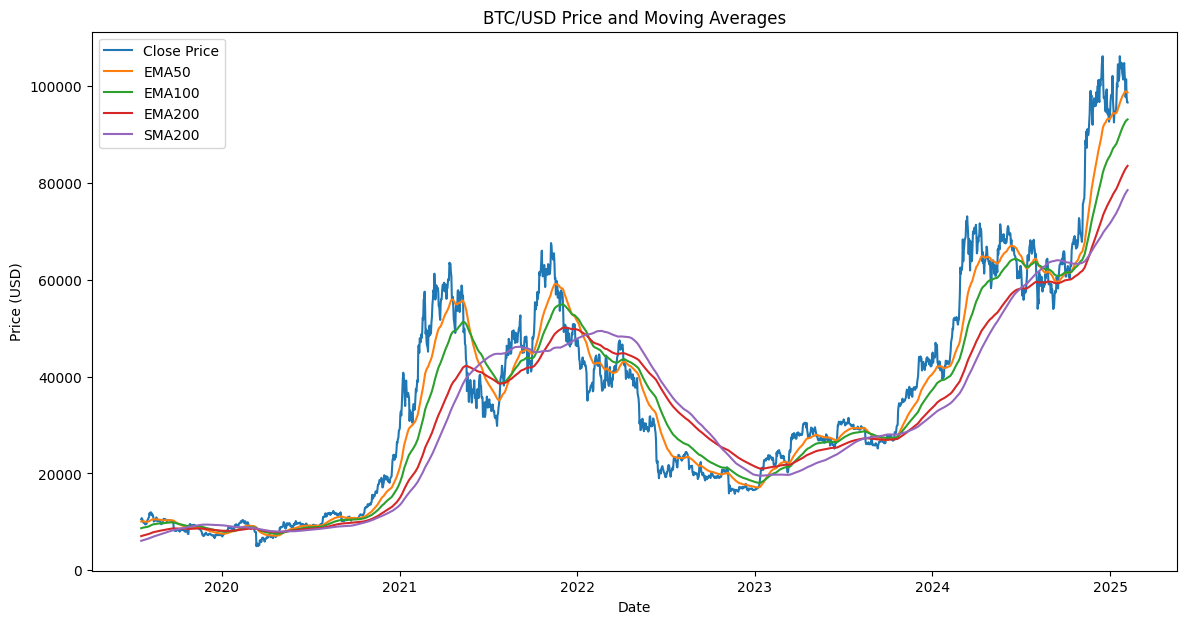

In [5]:
# 4. Visualize the data with matplotlib

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['ema50'], label='EMA50')
plt.plot(df['ema100'], label='EMA100')
plt.plot(df['ema200'], label='EMA200')
plt.plot(df['sma200'], label='SMA200')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("BTC/USD Price and Moving Averages")
plt.legend()
plt.show()

In [6]:
# 5. Prepare the dataset
# Select features and standardize them

features = ["Close", "High", "Low", "ema50", "ema100", "ema200", "sma200"]
data = df[features].values

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)



In [7]:
# Create a sliding window dataset

def create_sliding_window(data, input_window, output_window):
  X, y = [], []
  for i in range(len(data) - input_window - output_window + 1):
    X.append(data[i : i + input_window])

    y.append(data[i + input_window : i + input_window + output_window, 0])
  return np.array(X), np.array(y)

input_window = 1800
output_window = 10
X, y = create_sliding_window(data_scaled, input_window, output_window)

In [8]:
# Split into training and validation sets (80/20 split)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [10]:
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        # Apply sin to even indices; cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]



In [11]:
# Transformer Block (Encoder Layer)
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([layers.Dense(dff, activation='relu'), layers.Dense(d_model)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        # Self-attention
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [12]:
# Build the complete Transformer-based model
def build_transformer_model(input_window, num_features, output_window, d_model=64, num_layers=2, num_heads=8, dff=128, dropout_rate=0.1):
    inputs = layers.Input(shape=(input_window, num_features))

    # Project input features to d_model dimensions
    x = layers.Dense(d_model)(inputs)

    # Add positional encoding
    x = PositionalEncoding(d_model)(x)

    # Stack Transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, dff, dropout_rate)(x, training=True)

    # Use the last time step's output for prediction
    x = x[:, -1, :]  # shape: (batch, d_model)
    outputs = layers.Dense(output_window)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
# Define model parameters
num_features = len(features)  # Here, 7 features are used
model = build_transformer_model(input_window, num_features, output_window, d_model=64, num_layers=2, num_heads=8, dff=128, dropout_rate=0.1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse')

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1800, 7)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1800, 64)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding                  │ (None, 1800, 64)            │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 1800, 64)            │         149,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 1800, 64)            │         149,504 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 300,170 (1.15 MB)

 Trainable params: 300,170 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 7. Train the model
epochs = 50  # Increase epochs if needed for better performance
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - loss: 4.3924 - val_loss: 0.8317
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.8762 - val_loss: 0.5762
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.5857 - val_loss: 0.3521
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.4692 - val_loss: 0.1812
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.2831 - val_loss: 0.2147
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.2087 - val_loss: 0.0606
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.1526 - val_loss: 0.0605
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.1512 - val_loss: 0.0821
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.1158 - val_loss: 0.0608
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.1127 - val_loss: 0.0440
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.1092 - val_loss: 0.0392
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0964 - val_loss: 0.0331
Ep

In [15]:
# 8. Predict the next 10 days
# -------------------------------------------------------
# Take the last input_window days from the scaled data and add a batch dimension.
last_sequence = data_scaled[-input_window:]  # shape: (input_window, num_features)
last_sequence = np.expand_dims(last_sequence, axis=0)  # shape: (1, input_window, num_features)

In [16]:
# Use the trained model to predict the next 10 days (scaled predictions)
prediction_scaled = model.predict(last_sequence)
prediction_scaled = prediction_scaled.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [17]:
# Invert the scaling for the closing price (first feature)
predicted_close = prediction_scaled * scaler.scale_[0] + scaler.mean_[0]

In [18]:
print("\nPredicted BTC Closing Prices for the next 10 days:")
print(predicted_close)


Predicted BTC Closing Prices for the next 10 days:
[ 99447.414  99386.875 101742.76  102015.12  100327.875 102030.89
 104474.586 100962.77  103043.99  100825.34 ]


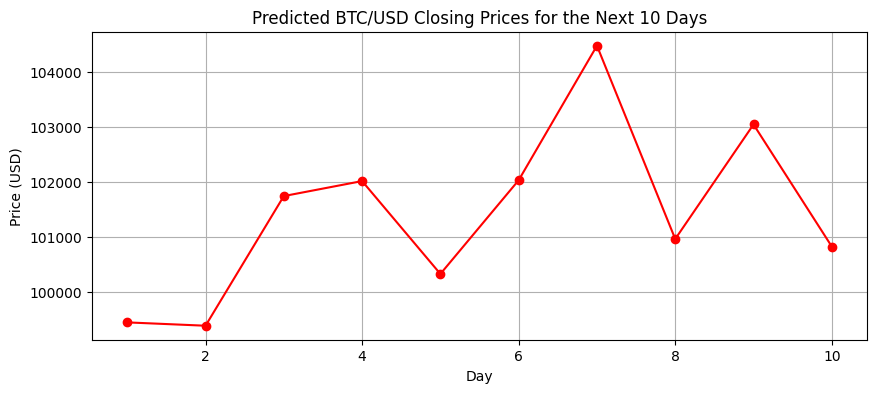

In [19]:
# (Optional) Plot the predicted closing prices
plt.figure(figsize=(10, 4))
plt.plot(range(1, output_window + 1), predicted_close, marker='o', linestyle='-', color='red')
plt.title("Predicted BTC/USD Closing Prices for the Next 10 Days")
plt.xlabel("Day")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()